# Generative Adversarial Networks for Beginners

## Build an artificial neural network that learns to generate handwritten digits.

### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

## Getting Started

We are going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans as well).  
We'll use [TensorFlow](https://www.tensorflow.org/), a deep learing library open-sourced by Google that makes it easy to train neural networks on GPUs.

## Loading MNIST Data

We'll need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images.  
In this tutorial, we are going to use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning.  
Let us begin by importing TensorFlow along with a couple of other helpful libraries.  
We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [8]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST variable we created above contains both the images and their labels, divided into a training set called `train` and a validation set called `validation`.  
We can retrieve batches of images by calling `next_batch` on `mnist`.  
Let's load up an image and have a look, shall we?  
The images are initially formatted as a single row of 784 pixels.  
We can reshape them into 28 x 28-pixel images and view them using pyplot.

(1, 784)


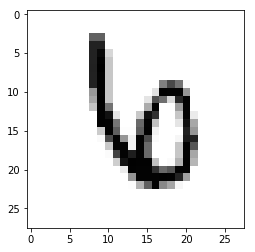

In [9]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image form the MNIST training set.

## The Discriminator Network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake" -- that is, whether it's drawn from the set of MNIST images or generated by the generator.  
The structure of the discriminator network features two convolutional layers that find 5 x 5 pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.  
To set up each layer, we start by creating weight and bias variables through `tf.get_variable`.  
Weights are initialized from a [truncated normal distribution](https://www.tensorflow.org/api_docs/python/tf/truncated_normal), and biases are initialized at zero.

`tf.nn.conv2d()` is TensorFlow's standard convolution function.  
It takes 4 arguments.  
The first is the input volume (our `28 x 28 x 1` images in this case).  
The next argument is the filter/weight matrix.  
Finally, you can also change the stride and padding of the convolution.  
those two values affect the dimensions of the output volume.  
If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier:

In [10]:
def discriminator(images, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()
        
    # First convolutional and pool layers.
    # This finds 32 different 5 x 5 pixel features:
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32],
                          initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32],
                          initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Second convolutional and pool layers.
    # This finds 64 different 5 x 5 pixel features:
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64],
                          initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64],
                          initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # First fully connected layer:
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024],
                          initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024],
                          initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)
    
    # Second fully connected layer:
    d_w4 = tf.get_variable('d_w4', [1024, 1],
                          initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1],
                          initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    
    # d4 contains unscaled values:
    return d4

Now that we have our discriminator defined, let's take a look at the generator model.

## The Generator Network